<a href="https://colab.research.google.com/github/seven320/Spacecat/blob/main/StyleGAN2_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [209]:
from typing import Tuple, List
from tqdm import tqdm

from PIL import Image

## train style GAN2 model for this cat doesn't exists

* prepare kaggle account and kaggle.json in your google drive

In [28]:
import os, sys
import shutil

COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
!cp drive/MyDrive/kaggle/kaggle.json /root/.kaggle/kaggle.json

In [22]:
!git clone https://github.com/seven320/stylegan2-pytorch.git
!pip install kaggle > /dev/null

fatal: destination path 'stylegan2-pytorch' already exists and is not an empty directory.


# Prepare Dataset

In [23]:
!kaggle datasets download -d crawford/cat-dataset

cat-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
shutil.unpack_archive("cat-dataset.zip")

In [32]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra

import enum
import numpy as np
import cv2 
from matplotlib import pyplot as plt
from keras.layers import *
import os

In [38]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    labels = load_labels(path)[1:]

    w,h = img.shape[:2]
    
    return img, labels , w , h

def load_labels(path):
    path = path + ".cat"
    
    with open(path,'r') as f:
        coordinates = f.readline()
        coordinates = str(coordinates).split(' ')[:-1]
    
    return list(map(int,coordinates))

CAT_00 00000049_012.jpg


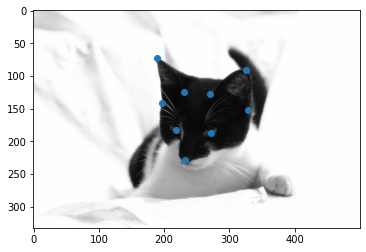

CAT_00 00000402_015.jpg


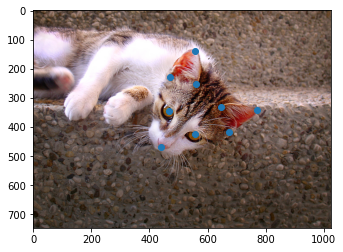

CAT_00 00000058_010.jpg


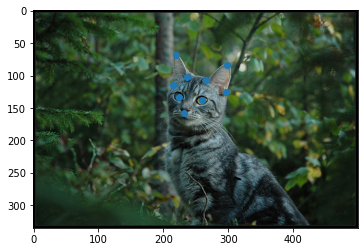

CAT_00 00000312_016.jpg


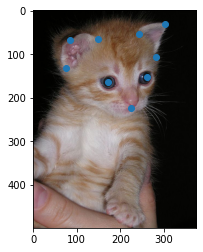

In [230]:
roots = [f"CAT_0{i}" for i in range(7)]
root = roots[0]
files = [i for i in os.listdir(root) if i.endswith(".jpg")]
for i, file in enumerate(files):
    print(root, file)
    x,y,w,h = load_image(os.path.join(root,file))
    plt.imshow(x)
    plt.scatter(y[0:18:2], y[1:18:2])
    plt.show()
    if i == 3:
        break

In [143]:
def cut_cats_center(image:np.ndarray, y:List[int], h:int, w:int) -> np.ndarray:
    """
    cut cat's image into a square with the cat's face in the center
    """
    x_min = min(y[0:18:2])
    x_max = max(y[0:18:2])
    y_min = min(y[1:18:2])
    y_max = max(y[1:18:2])

    # calculate cat face position
    x_center =(x_min + x_max) /2
    y_center = (y_min + y_max) / 2

    half_w = min(x_center, w - x_center)
    half_h = min(y_center, h - y_center)
    half_edge = min(half_w, half_h)

    y_s = int(y_center - half_edge)
    y_e = int(y_center + half_edge)
    x_s = int(x_center - half_edge)
    x_e = int(x_center + half_edge)
    assert y_e-y_s == x_e-x_s
    return image[y_s:y_e, x_s:x_e]


In [221]:
if not os.path.exists("prepare_data/cats"):
    os.makedirs("prepare_data/cats")

roots = [f"CAT_0{i}" for i in range(7)]
total_index = 0
for root in tqdm(roots):
    files = [i for i in os.listdir(root) if i.endswith(".jpg")]
    for i, file in enumerate(files):
        if os.path.exists(f"data/cats/{total_index:04}.jpg"):
            total_index += 1
            continue
        image, label,w,h = load_image(os.path.join(root,file))
        c_image = cut_cats_center(image, label, w, h)
        try:
            Image.fromarray(c_image).save(f"prepare_data/cats/{total_index:04}.jpg")
            total_index += 1
        except:
            pass

100%|██████████| 7/7 [02:37<00:00, 22.51s/it]


In [ ]:
path = "prepare_data/cats_0000.jpg"
img = cv2.imread(path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
# labels = load_labels(path)[1:]
plt.imshow(img)
plt.show()

In [228]:
!python stylegan2-pytorch/prepare_data.py --out prepare_data --size 512 --n_worker 4 /content/prepare_data

Make dataset of image sizes: 512
0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:405: UserWarning: 

# Train StyleGAN2